In [1]:
# Import packages
import torch
import numpy as np
import normflows as nf

from matplotlib import pyplot as plt

from tqdm import tqdm

import numpy as np
import uproot as up
import pandas as pd
import matplotlib.pyplot as plot
from scipy.stats import norm
from scipy.optimize import curve_fit
import sympy
from IPython.display import clear_output
import math
import time

In [2]:
# Get device to be used
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Emission time

In [3]:
# Data - closest x pos, 5GeV muons, one z position - emission time
uproot_path = f"/home/rowan/eic/work_eic/root_files/June_26/check_hit_time_scint_sens/mu/5GeV_2k_1720_w_optph.edm4hep.root:events" #(gun x 1769)
# uproot_path = f"/home/rowan/eic/work_eic/root_files/June_26/variation_x_pos/mu_run_2/varied_x_7.edm4hep.root:events" #(gun x 1720)
events = up.open(uproot_path)

In [4]:
hit_time_branch = events["HcalBarrelHits.time"].array(library='np')
hit_x_pos_branch = events["HcalBarrelHits.position.x"].array(library='np')
Hits_MC_idx_branch = events["_HcalBarrelHits_MCParticle.index"].array(library='np')


x_pos_branch = events["MCParticles/MCParticles.vertex.x"].array(library='np')
PDG_branch = events["MCParticles.PDG"].array(library='np')
emission_time_branch = events["MCParticles/MCParticles.time"].array(library='np')
daughter_end_branch = events["MCParticles/MCParticles.daughters_end"].array(library='np')
daughter_begin_branch = events["MCParticles/MCParticles.daughters_begin"].array(library='np')

In [28]:
break_idx = 500
mu_hit_count = np.zeros(min(len(PDG_branch),break_idx))
optph_count = np.zeros(min(len(PDG_branch),break_idx))

emission_time_list = []
mu_hit_time_list = []
optph_x_vertex_list = []
mu_hit_x_list = []

mu_hit_x_dist = np.zeros(70)
mu_hit_time_dist = np.zeros(70)

skipped_count = 0

for event_idx in range(len(PDG_branch)):
    if(event_idx >= break_idx):
        break
    daughter_begin = daughter_begin_branch[event_idx][0]
    daughter_end = daughter_end_branch[event_idx][0]
    for hit_idx in range(len(Hits_MC_idx_branch[event_idx])):
        hit_MC_idx = Hits_MC_idx_branch[event_idx][hit_idx]
        if(hit_MC_idx == 0):
            try:
                mu_hit_x_dist[int(mu_hit_count[event_idx])] += hit_x_pos_branch[event_idx][hit_idx]
                mu_hit_time_dist[int(mu_hit_count[event_idx])] += hit_time_branch[event_idx][hit_idx]
            except IndexError as e:
                skipped_count += 1
            mu_hit_count[event_idx] += 1
            mu_hit_time_list.append(hit_time_branch[event_idx][hit_idx])
    for part_idx in range(len(PDG_branch[event_idx])):
        if(PDG_branch[event_idx][part_idx] != -22):
            continue
        if(part_idx < daughter_begin or part_idx >= daughter_end):
            continue
        optph_count[event_idx] += 1
        emission_time_list.append(emission_time_branch[event_idx][part_idx])
        optph_x_vertex_list.append(x_pos_branch[event_idx][part_idx])
mu_hit_x_dist = mu_hit_x_dist / break_idx
mu_hit_time_dist = mu_hit_time_dist / break_idx

mu_hit_count: 70
mu_hit_count: 70
mu_hit_count: 70
mu_hit_count: 70
mu_hit_count: 70
mu_hit_count: 70
mu_hit_count: 70
mu_hit_count: 70
mu_hit_count: 70
mu_hit_count: 71
mu_hit_count: 70
mu_hit_count: 70
mu_hit_count: 70
mu_hit_count: 70
mu_hit_count: 70
mu_hit_count: 70
mu_hit_count: 70


### Hit time and hit position of mu
Can see below that the relationship is linear

/tmp/ipykernel_8104/3654242464.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_dist.show()


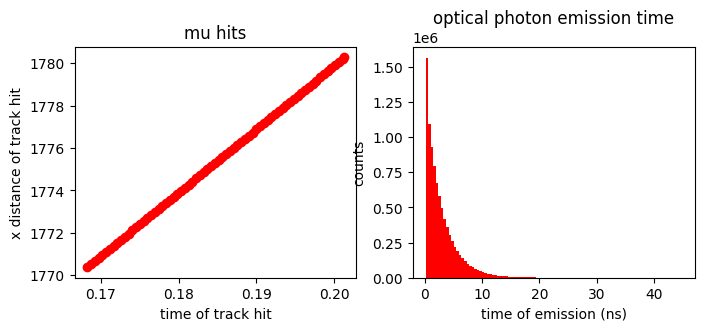

In [37]:
fig_dist, ax_dist = plot.subplots(1,2, figsize=(8,3))
ax_dist[0].scatter(mu_hit_time_dist,mu_hit_x_dist, color = 'r');
ax_dist[0].set_title("mu hits")
ax_dist[0].set_ylabel("x distance of track hit")
ax_dist[0].set_xlabel("time of track hit")
ax_dist[1].hist(emission_time_list, bins = 100, color = 'r');
ax_dist[1].set_title("optical photon emission time")
ax_dist[1].set_ylabel("counts")
ax_dist[1].set_xlabel("time of emission (ns)")
fig_dist.show()
fig_dist.savefig("plots/mu_track_hit/mu_hit_distance_time_w_photon_emission.jpeg")

In [42]:
len(emission_time_list)

8979021

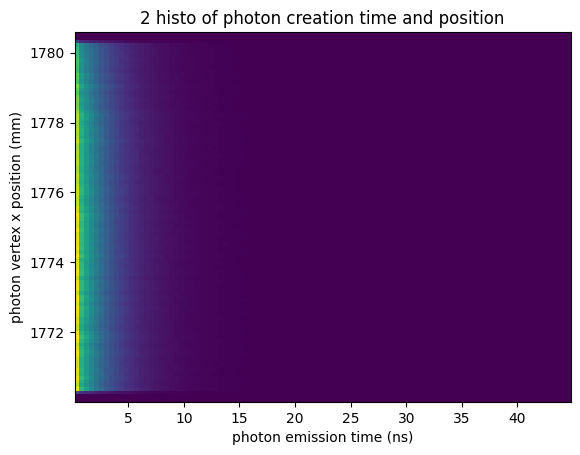

In [44]:
plot.hist2d(emission_time_list,optph_x_vertex_list, bins = 100);
plot.xlabel("photon emission time (ns)")
plot.ylabel("photon vertex x position (mm)")
plot.title("2 histo of photon creation time and position")
plot.savefig("plots/mu_track_hit/photon_creation_time_position.jpeg")

Text(0.5, 0, 'time of hit in scintillator (ns)')

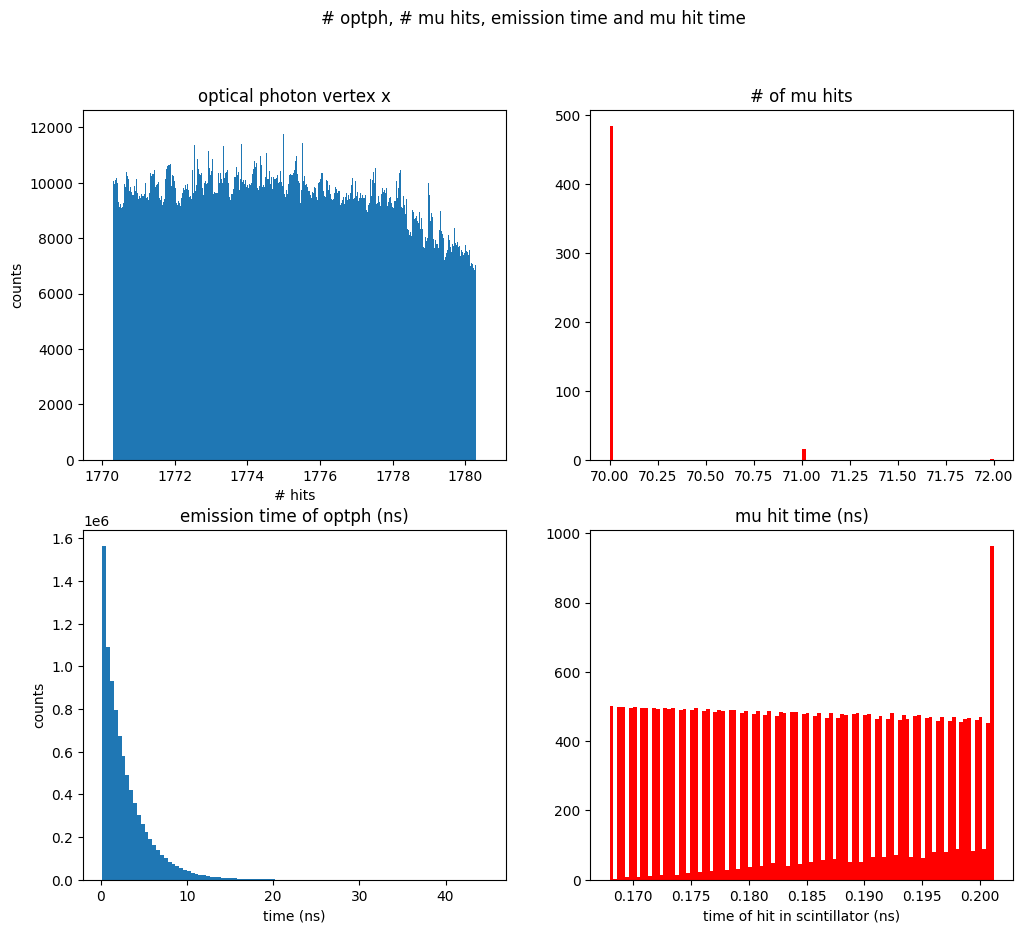

In [36]:
fig, axs = plot.subplots(2,2, figsize = (12,10))
fig.suptitle("# optph, # mu hits, emission time and mu hit time")

axs[0,0].hist(optph_x_vertex_list,bins = 1000);
axs[0,0].set_title("optical photon vertex x")
axs[0,0].set_ylabel("counts")
axs[0,0].set_xlabel("x position (mm)")
axs[0,1].hist(mu_hit_count,bins = 100, color = 'r');
axs[0,1].set_title("# of mu hits")
axs[0,0].set_xlabel("# hits")

emission_time_hist = axs[1,0].hist(emission_time_list,bins = 100);
axs[1,0].set_title("emission time of optph (ns)")
axs[1,0].set_ylabel("counts")
axs[1,0].set_xlabel("time (ns)")
axs[1,1].hist(mu_hit_time_list,bins = 100, color = 'r');
axs[1,1].set_title("mu hit time (ns)")
axs[1,1].set_xlabel("time of hit in scintillator (ns)")



# fig.savefig("plots/num_optph_mu_hits_emission_mu_hit_time_5GeV_2kevents_1720.jpeg")

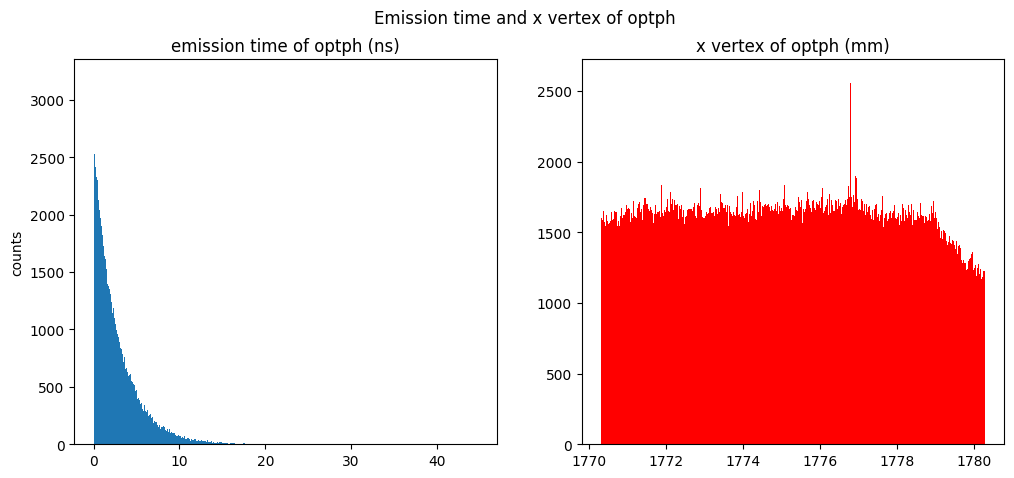

In [72]:
fig, axs = plot.subplots(1,2, figsize = (12,5))
fig.suptitle("Emission time and x vertex of optph")
emission_time_hist = axs[0].hist(emission_time_list,bins = 100000);
axs[0].set_title("emission time of optph (ns)")
axs[0].set_ylabel("counts")
axs[1].hist(x_vertex_list,bins = 10000, color = 'r');
axs[1].set_title("x vertex of optph (mm)")
fig.savefig("plots/emission_x_vertex_1770_299.jpeg")

In [73]:
print(f"idx: {0} | N: {emission_time_hist[0][i]} | bin: {emission_time_hist[1][i]}\nidx: {1} | N: {emission_time_hist[0][i + 1]} | bin: {emission_time_hist[1][i + 1]}")

idx: 0 | N: 970.0 | bin: 4.929706392431399e-06
idx: 1 | N: 1059.0 | bin: 0.00045268714893609285


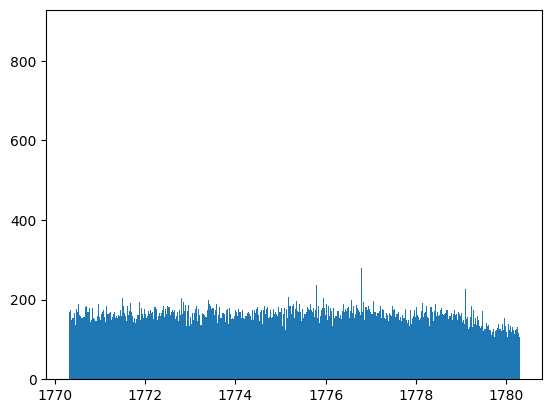

In [74]:
N, bins, patches = plot.hist(x_vertex_list, bins = 100000);

In [75]:
for i in range(len(N)):
    if N[i] < 2:
        continue
    print(f"idx: {i} | N: {N[i]} | bin: {bins[i]}\nidx: {i + 1} | N: {N[i + 1]} | bin: {bins[i + 1]}")
    break

idx: 0 | N: 171.0 | bin: 1770.3000010388093
idx: 1 | N: 148.0 | bin: 1770.3001010387877
